# Foraminifera clusterization
## Author: Benjamín Antonio Velasco Guzmán [GitHub: BenjaminGuzman](https://github.com/BenjaminGuzman)

In [1]:
# Utils
import numpy as np
import os
from shutil import rmtree as rm_dir

# Image processing
from PIL import Image
import cv2

# Machine Learning
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
INPUT_DIR_DATA = os.path.abspath("img")
OUT_RESIZED_IMAGES = os.path.abspath("resized_images")
OUT_RESIZED_IMAGES_BIN = os.path.abspath("resized_images_bin")
OUT_CLASSIFIED_IMAGES = os.path.abspath("out")
OUT_ROTATED_IMAGES = os.path.abspath("rotated_images")

## Load images & convert to greyscale

In [3]:
files = os.listdir(INPUT_DIR_DATA)

images = []
for i, file in enumerate(files):
    image = Image.open("{}/{}".format(INPUT_DIR_DATA, file))
    image = np.array(image, dtype=np.uint8)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    images.append(image)

## Standarize height and width with averages & binarize

In [4]:
images_resized = []
images_resized_bin = []

# Obtain mean height and mean width
mean_width, mean_height = 0, 0
for image in images:
    mean_width += image.shape[0]
    mean_height += image.shape[1]

total_images = len(images)
mean_width //= total_images
mean_height //= total_images

# Resize images
for i, image in enumerate(images):
    resized_image = cv2.resize(image, (mean_width, mean_width))
    _, resized_image_bin = cv2.threshold(resized_image, 50, 255, cv2.THRESH_BINARY)
    images_resized_bin.append(np.asarray(resized_image_bin, dtype=np.uint8))
    images_resized.append(np.asarray(resized_image, dtype=np.uint8))

images_np_bin = np.asarray(images_resized_bin, dtype=np.uint8)
images_np = np.asarray(images_resized, dtype=np.uint8)
print(images_np_bin.shape)

(453, 84, 84)


### Save resized and binarized images

In [5]:
if not os.path.isdir(OUT_RESIZED_IMAGES):
    os.mkdir(OUT_RESIZED_IMAGES)
if not os.path.isdir(OUT_RESIZED_IMAGES_BIN):
    os.mkdir(OUT_RESIZED_IMAGES_BIN)
    
for i, image in enumerate(images_np_bin):
    cv2.imwrite("{}/resized_0{}.png".format(OUT_RESIZED_IMAGES_BIN, i), image)

for i, image in enumerate(images_np):
    cv2.imwrite("{}/resized_0{}.png".format(OUT_RESIZED_IMAGES, i), image)

## Find center for each row
This will give tha main line of the image, like PCA

In [49]:
main_lines = []
for image in images_np_bin:
    main_line = []
    for row_index, row in enumerate(image):
        active_pixels = [j for j, pixel in enumerate(row) if pixel == 255]
        if len(active_pixels) == 0:
            continue
        main_line.append([row_index, int(round(sum(active_pixels) / len(active_pixels)))])
    main_lines.append(np.array(main_line))

main_lines = np.array(main_lines)

## Plot results
- **red**: main_line 
- **white**: aproximated main line (its arctan(m) is the angle of inclination of the image)

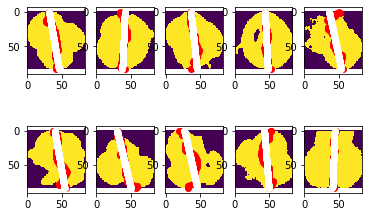

In [50]:
for i in range(10):
    image = images_np_bin[i]
    plt.subplot(2, 5, i + 1)
    plt.imshow(image)
    main_line = main_lines[i]
    plt.scatter(main_line[:, 1], main_line[:, 0], c="#FF0000")
    
    # linearization
    approx_m, approx_b = np.polyfit(main_line[:, 0], main_line[:, 1], 1)
    x = [i for i in range(84)]
    y = [approx_m * i + approx_b for i in x]
    plt.scatter(y, x, c="#FFFFFF")

plt.show()

## Rotate images
Rotate images using the angle of the white line (see above)

In [51]:
rotated_images = []
for i, image in enumerate(images_np_bin):
    main_line = main_lines[i]
    approx_m, approx_b = np.polyfit(main_line[:, 0], main_line[:, 1], 1)
    rotation_angle = -np.degrees(np.arctan(approx_m))
    
    rotation_matrix = cv2.getRotationMatrix2D((42, 42), rotation_angle, 1)
    rotated = cv2.warpAffine(image, rotation_matrix, (84, 84))
    rotated_original = cv2.warpAffine(images_resized[i], rotation_matrix, (84, 84))
    cv2.imwrite("{}/rotated_0{}.png".format(OUT_ROTATED_IMAGES, i), rotated_original)
    rotated_images.append(np.array(rotated))

rotated_images = np.array(rotated_images)
images_np_bin = rotated_images

### Prepare for PCA

In [52]:
prep_images = []
for image in images_np_bin:
    prep_image = image.flatten()
    prep_images.append(prep_image)
    
prep_images = np.asarray(prep_images, dtype=np.uint8)

#### Normalization & standarization

In [53]:
images_norm = normalize(prep_images)
"""
scaler = StandardScaler()
scaler.fit(pca_images)
images_std = scaler.transform(prep_images)
"""

'\nscaler = StandardScaler()\nscaler.fit(pca_images)\nimages_std = scaler.transform(prep_images)\n'

### Apply PCA (for data visualization grid)

In [57]:
pca = PCA(n_components=0.9)
pca_images_norm = pca.fit_transform(images_norm)
print("Shapes")
print(pca.components_.shape)
print("Before: {} \t After: {}".format(images_np_bin.shape, pca_images_norm.shape))

Shapes
(100, 7056)
Before: (453, 84, 84) 	 After: (453, 100)


## Visualize PCA results

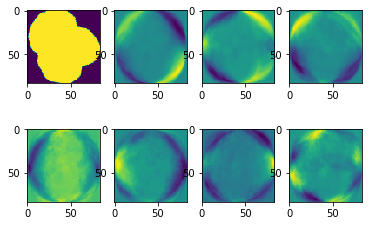

In [58]:
"""
def pca_results(x, coeff, labels=None):
    plt.scatter(x[:, 0], x[:, 1])
    n = coeff.shape[0]
    
    for i in range(n):
        plt.arrow(0, 0, coeff[i, 0], coeff[i, 1], color='r', alpha=0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')

pca_results(pca_images[:, 0:2], pca.components_)
plt.show()
"""
"""
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(pca_images[i].reshape(9, 9), cmap="gray")

for i in range(5):
    plt.subplot(2, 5, 6 + i)
    plt.imshow(images_np_bin[i], cmap="gray")

plt.show()
"""
plt.subplot(2,4,1)
plt.imshow(prep_images[0].reshape(84, 84))
for i in range(7):
    plt.subplot(2,4,i+2)
    plt.imshow(pca.components_[i].reshape(84, 84))

### Plot first & second & third components

In [59]:
def plot3d(X, Y, Z, colors=None, title="3D PCA"):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X, Y, Z, c=colors)
    plt.title(title)
    plt.show()

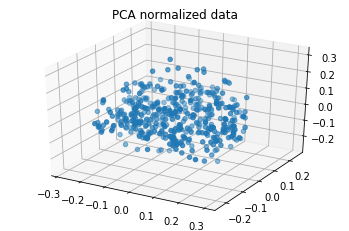

In [60]:
plot3d(pca_images_norm[:, 0], pca_images_norm[:, 1], pca_images_norm[:, 2], title="PCA normalized data")

In [61]:
# plot3d(pca_images_std[:, 0], pca_images_std[:, 1], pca_images_std[:, 2], title="PCA standarized data")

## Elbow method

Identify optimal number of clusters (it should be equal to the amount of foraminifera species we've in the lab)

In [62]:
def elbow(Y, title="Elbow", range_elbow=range(1, 9)):
    distorsions = []
    for k in range_elbow:
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(Y)
        distorsions.append(kmeans.inertia_)

    fig = plt.figure(figsize=(15, 5))
    plt.scatter(range_elbow, distorsions)
    plt.plot(range_elbow, distorsions)
    plt.grid(True)
    plt.title(title)
    print(distorsions)

[45.77051961590196, 39.76147262634029, 37.164475980117075, 35.41639649001873, 34.032828261353195, 32.768272834263506, 31.627536170819205, 30.848066259744947]


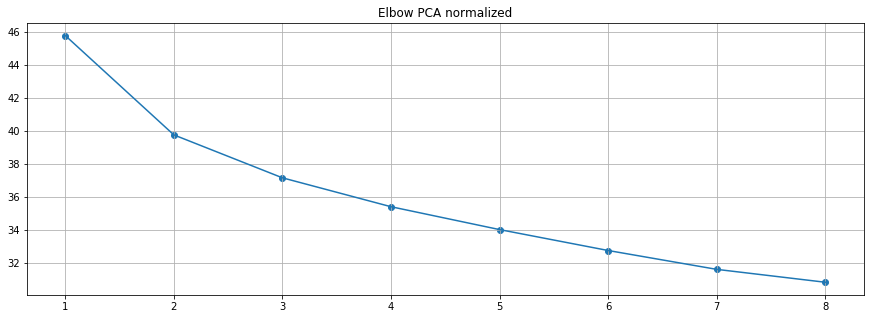

In [63]:
elbow(pca_images_norm, title="Elbow PCA normalized")

In [64]:
# elbow(pca_images_norm, title="Elbow PCA standarized")

In [65]:
def try_kmeans(Y, n_clusters=2):
    clustering = KMeans(n_clusters=n_clusters)

    trained_kmeans = clustering.fit(Y)
    print(trained_kmeans.labels_)
    
    labels = trained_kmeans.predict(Y)
    colors = []
    colors_dict = {
        0: "#FF0000",
        1: "#00FF00",
        2: "#0000FF",
        3: "#FF00FF",
        4: "#FFFF00",
        5: "#00FFFF",
        6: "#F0F0F0",
        7: "#0F0F0F",
        8: "#FF0F00",
        9: "#FF000F"
    }
    
    for i, image in enumerate(Y):
        colors.append(colors_dict[labels[i]])
    
    plot3d(Y[:, 0], Y[:, 1], Y[:, 2], colors=colors)
    
    return labels

[6 9 6 3 4 4 0 2 8 3 7 3 0 0 5 0 9 5 2 0 6 0 5 9 7 2 7 3 8 0 0 6 4 2 8 5 3
 2 9 7 8 3 4 3 1 1 3 3 6 3 5 1 9 1 7 5 0 1 5 4 3 7 5 1 9 3 7 5 4 3 3 6 1 8
 3 1 7 7 9 3 2 1 1 0 1 4 8 0 6 1 6 4 7 1 5 2 5 1 4 7 8 0 2 5 5 6 0 0 3 6 8
 3 3 6 5 2 0 0 3 0 6 3 6 0 2 2 0 1 7 1 7 0 7 0 3 8 7 7 8 9 3 9 5 8 8 3 5 2
 3 7 7 8 6 6 3 1 3 1 2 0 1 1 4 1 9 4 0 7 0 7 0 4 2 0 3 3 2 7 7 3 4 8 0 1 0
 7 1 1 3 6 5 7 6 7 5 7 2 8 7 8 2 0 2 7 2 7 5 0 9 5 8 8 8 2 6 3 0 8 4 6 2 5
 8 4 4 7 4 7 2 0 8 0 1 0 7 0 7 9 6 0 0 5 0 4 1 9 0 7 3 5 3 8 8 6 6 0 2 5 5
 6 9 9 5 7 2 7 2 7 5 2 9 8 3 8 4 7 8 4 6 6 0 0 7 4 0 8 5 4 6 9 0 1 7 6 7 9
 8 7 8 0 5 8 7 2 4 5 2 0 0 8 7 4 3 2 7 5 7 9 9 7 5 5 0 8 5 5 0 0 9 1 8 8 8
 2 0 5 0 0 1 6 0 9 0 4 4 3 2 8 2 5 7 8 7 9 0 4 2 3 8 7 2 7 8 7 8 8 2 4 7 9
 7 2 3 3 7 7 4 6 8 1 3 7 9 4 1 2 7 2 1 2 0 8 5 8 4 3 8 8 7 3 7 1 1 9 8 4 3
 7 3 5 0 1 1 7 5 8 5 3 4 3 4 9 7 6 4 2 7 7 9 1 0 7 7 8 9 3 7 8 3 8 7 7 0 3
 8 3 2 4 3 5 9 7 5]


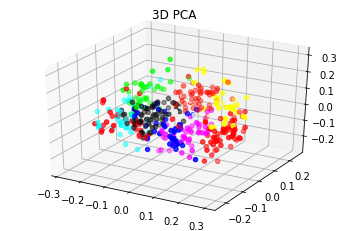

In [66]:
labels = try_kmeans(pca_images_norm, 10)

In [67]:
def save_clustered_images(labels):
    
    rm_dir(OUT_CLASSIFIED_IMAGES)
    os.mkdir(OUT_CLASSIFIED_IMAGES)

    counters = {}
    for label in labels:
        counters[label] = 0

        out_dir_label = "{}/0{}".format(OUT_CLASSIFIED_IMAGES, label)
        if not os.path.isdir(out_dir_label):
            os.mkdir(out_dir_label)

    for i, image in enumerate(images_resized):
        save_path = "{}/0{}/{}.png".format(OUT_CLASSIFIED_IMAGES, labels[i], counters[labels[i]])
        counters[labels[i]] += 1
        cv2.imwrite(save_path, image)

In [68]:
save_clustered_images(labels)